In [1]:
#ONLY FOR STARMON 5

import numpy as np
import qiskit as qk
import math
from qiskit import Aer
import os


from calibration_functions import *  
# Functions:
# get_readout_err(experimental_backend, number_of_shots)      find calibrating matrix B 
# calibrate_readout_err(exper_expect_val , B)       find calibrated exp_value vector

from transfer_matrix_tools import *
# Functions:
# calculate_gate_fidelity(n, Transfer_matrix_ideal,Transfer_matrix)     n=number f qubits
# calculate_transfer_matrix(input_expected_values,output_expected_values)
# plot_transfer_matrix(Transfer_matrix)

from theoretical_tools import *
# Functions:
# exp_value_braket(statevector,operator)

from backend_tools import *
# Functions:
# IBM_backend('ibm_backend')
# QI_backend('qi_backend' )
# simulator_backend()
# noisy_simulator_backend()

In [2]:
#BACKEND AND NUMBER OF SHOTS

experimental_backend = QI_backend('Starmon-5')
number_of_shots = 8192
experiment_name='  '

In [3]:
states = [np.array([1,0]),np.array([0,1]),1/np.sqrt(2) * np.array([1,1]), \
          1/np.sqrt(2) * np.array([1,-1]), 1/np.sqrt(2) * np.array([1, complex(0,1)]), 1/np.sqrt(2) * np.array([1, complex(0,-1)])]
possible_directions = ['I', 'X','Y', 'Z']


experiment_directory=os.path.join('data_collected', experiment_name)

#if the folder does not exist, create it
if not os.path.exists(experiment_directory):
    os.makedirs(experiment_directory)


#PAULI GATES
pauli_g=np.zeros((4,2,2),dtype = np.complex_)
pauli_g[0] = np.array([[1,0],[0,1]]) 
pauli_g[1] = np.array([[0,1],[1,0]]) 
pauli_g[2] = np.array([[0,complex(0,-1)],[complex(0,1),0]]) 
pauli_g[3] = np.array([[1,0],[0,-1]])

sv_backend = Aer.get_backend('statevector_simulator') #statevector for theoretical transfer matrix


#get calibration data

B=get_readout_err(experimental_backend, 8192)

np.save( os.path.join(experiment_directory, 'B'), B )


sv_expected_values=np.zeros((36, 16))
precalibration_exp_values=np.zeros((36, 16))
output_expected_values = np.zeros((36, 16))
input_expected_values = np.zeros((36, 16))


m=0                      # goes from 0 to 35 (36 cardinal states)
for state1 in states:
    for state2 in states:
        d1d2=0           # direction 1 + direction 2 numbering  -  goes from 0 to 15
        d1=0             # direction 1 numbering
        n=0              # goes from 0 to 8 (9 experiments per cardinal state ) 
        for direction1 in possible_directions:
            d2=0         #direction 2 numbering
            for direction2 in possible_directions:
                
                input_state_vector=np.kron( state2 , state1)
                
                total_direction_matrix = np.kron(pauli_g[d2],pauli_g[d1]) 
                
                input_expected_values[m,d1d2]=  exp_value_braket(input_state_vector, total_direction_matrix )    # <'Direction2' 'Direction1'> =  <bra| D2D1_matrix   |ket> 
            
  
                
                combined_directions = direction1 + direction2
                if combined_directions == 'II' : # For the II case we don't need a circuit
                    output_expected_values[m,0] = 1
                    precalibration_exp_values[m,0] = 1
                    sv_expected_values[m,0]=1
                    d2+=1
                    d1d2+=1
                    continue  
                #print("Let's find the expectation value for the", direction1, direction2, 'measurements')
                
                # Define circuit
                q = qk.QuantumRegister(3)
                c = qk.ClassicalRegister(3)
                circuit = qk.QuantumCircuit(q, c)
                
                # Do some initialization for the input states
                circuit.initialize(states[0], 0)
                circuit.initialize(state1, 1)  # Initialize the 0th qubit using a complex vector
                circuit.initialize(state2, 2)  # Initialize the 1st qubit using a complex vector
                    
                                #INPUT PROCESS
                                
                # The gates for the process
                #circuit.h(q[0])
                circuit.cz(q[1], q[2])
                
                ## STATEVECTOR DOES NOT WORK FOR STARMON-5. USE THEORETICAL OUTPUT FROM NORMAL IMPLEMENTATION 


                d1d2+=1  #iterating d1d2 used for theoretical exp values
                


                #EXPERIMENT ON THE BACKEND FROM NOW ON

                # Rotate to make measurements in different bases // go on to experiment only if neither direction is I 
                if direction1 == 'I' :
                    d2+=1
                    continue 
                elif direction1 == 'X' : 
                    circuit.ry(-math.pi/2, q[1])
                elif direction1 == 'Y' : 
                    circuit.rx(math.pi/2, q[1])
                
                if direction2 == 'I' :
                    d2+=1
                    continue 
                elif direction2 == 'X' : 
                    circuit.ry(-math.pi/2, q[2])
                elif direction2 == 'Y' : 
                    circuit.rx(math.pi/2, q[2])


                circuit.measure(q, c)    # Measure both bits

                # Define the experiment

 
                experimental_job = qk.execute(circuit, backend=experimental_backend, shots=number_of_shots)
                experimental_result = experimental_job.result()

                # Look at the results
                histogram = experimental_result.get_counts(circuit)
                
                # Add the results to the results matrix
                expected_value=np.zeros(3)
                for state, counts in histogram.items() :
                    expected_value[0] += (-1)**(int(state[1]))*int(counts)    #corresponds to IZ            
                    expected_value[1] += (-1)**(int(state[0]))*int(counts)    #corresponds to ZI               
                    expected_value[2] += (-1)**(int(state[1])+int(state[0]))*int(counts)   #corresponds to ZZ

                expected_value = expected_value / number_of_shots

                calibrated_exp_val=calibrate_readout_err(expected_value,B)
            

                ## Calculation of <U,U>
                output_expected_values[ m ,4*d1+d2] = calibrated_exp_val[2]
                precalibration_exp_values[ m ,4*d1+d2] = expected_value[2]

                ## Calculation of <I,U>  
                output_expected_values[ m ,d2] = calibrated_exp_val[1]
                precalibration_exp_values[ m ,d2] = expected_value[1]
                
                ## Calculation of <U,I>  
                output_expected_values[ m ,4*d1] = calibrated_exp_val[0]
                precalibration_exp_values[ m ,4*d1] = expected_value[0]


                #save data
                np.save(os.path.join(experiment_directory, 'output_expected_values')     ,output_expected_values)
                np.save(os.path.join(experiment_directory, 'precalibration_exp_values')  ,precalibration_exp_values)
                np.save(os.path.join(experiment_directory, 'sv_expected_values' )        ,sv_expected_values)
                np.save(os.path.join(experiment_directory, 'input_expected_values')      ,input_expected_values)

                print(' m = ',m,' n = ',n) #TRACK THE PROGRESS
                n += 1
                d2+=1
            d1+=1
        m += 1

Calibration has begun.

[[ 1.91650391e-02  9.51049805e-01  4.15039062e-03 -2.44140625e-04]
 [ 3.96728516e-02 -1.22070312e-04  9.36767578e-01  2.92968750e-03]
 [ 4.27246094e-03  3.62548828e-02  2.13623047e-02  8.93432617e-01]]
Calibration done!

 m =  0  n =  0
 m =  0  n =  1
 m =  0  n =  2
 m =  0  n =  3
 m =  0  n =  4
 m =  0  n =  5
 m =  0  n =  6
 m =  0  n =  7
 m =  0  n =  8
 m =  1  n =  0
 m =  1  n =  1
 m =  1  n =  2
 m =  1  n =  3
 m =  1  n =  4
 m =  1  n =  5
 m =  1  n =  6
 m =  1  n =  7
 m =  1  n =  8
 m =  2  n =  0
 m =  2  n =  1
 m =  2  n =  2
 m =  2  n =  3
 m =  2  n =  4
 m =  2  n =  5
 m =  2  n =  6
 m =  2  n =  7
 m =  2  n =  8
 m =  3  n =  0
 m =  3  n =  1
 m =  3  n =  2
 m =  3  n =  3
 m =  3  n =  4
 m =  3  n =  5
 m =  3  n =  6
 m =  3  n =  7
 m =  3  n =  8
 m =  4  n =  0
 m =  4  n =  1
 m =  4  n =  2
 m =  4  n =  3
 m =  4  n =  4
 m =  4  n =  5
 m =  4  n =  6
 m =  4  n =  7
 m =  4  n =  8
 m =  5  n =  0
 m =  5  n =  1
 m 

In [2]:
#ACCESS DATA AND GET RESULTS


experiment_name='Identity_starmon5_8192_13_1' #  INPUT EXPERIMENTAL IDENTITY
experiment_directory=os.path.join('data_collected', experiment_name)
exp_input_expected_values= np.load(os.path.join(experiment_directory, 'output_expected_values.npy') )

experiment_name='cnot_starmon5_8192_12_1'  # INPUT EXPERIMENTAL OUTPUT
experiment_directory=os.path.join('data_collected', experiment_name)
B                    =np.load(os.path.join(experiment_directory, 'B.npy') ) 
input_expected_values=np.load(os.path.join(experiment_directory, 'input_expected_values.npy') )
precalibration_exp_values=np.load(os.path.join(experiment_directory, 'precalibration_exp_values.npy') )
sv_expected_values=np.load(os.path.join(experiment_directory, 'sv_expected_values.npy') )
output_expected_values=np.load(os.path.join(experiment_directory, 'output_expected_values.npy') )

##CAUTION: STATEVECTOR DOES NOT WORK FOR STARMON-5. USE THEORETICAL OUTPUT FROM NORMAL IMPLEMENTATION 

th_transfer_matrix = calculate_transfer_matrix( input_expected_values, sv_expected_values ) 
exp_transfer_matrix = calculate_transfer_matrix( input_expected_values, output_expected_values )  #experimental output with ideal input

exp_inp_transfer_matrix = calculate_transfer_matrix( exp_input_expected_values , output_expected_values )  #experimental output with experimental input


In [3]:
#average gate fidelity
calculate_gate_fidelity(2, th_transfer_matrix , exp_inp_transfer_matrix)

0.9677619432498481

In [4]:
#error through bootstrapping
get_bootstrap_standard_error(2 , 8192 , 1000 , input_expected_values , output_expected_values , sv_expected_values,exp_input_expected_values)

0.0013632100017316338

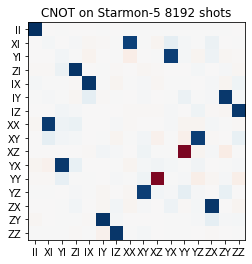

In [5]:
plot_transfer_matrix(exp_inp_transfer_matrix,'CNOT on Starmon-5 8192 shots')